In [ ]:
# default_exp models.plmodules

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from grade_classif.data.dataset import ImageClassifDataset, NormDataset
from grade_classif.data.transforms import get_transforms
from grade_classif.data.utils import show_img
from grade_classif.models.utils import named_leaf_modules, get_sizes, get_num_features, gaussian_mask
from grade_classif.models.modules import DynamicUnet, bn_drop_lin, CBR
from grade_classif.models.losses import FocalLoss, BCE
from grade_classif.core import ifnone
from grade_classif.imports import *
import pytorch_lightning as pl
from pytorch_lightning.logging import CometLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau

In [ ]:
#export
def _get_loss(loss_name, weight, reduction, device='cpu'):
    if loss_name == 'cross-entropy':
        loss = nn.CrossEntropyLoss(torch.tensor([weight, 1.], device=device), reduction=reduction)
    elif loss_name == 'bce':
        loss = BCE(reduction=reduction, pos_weight=torch.tensor([1/weight], device=device))
    elif loss_name == 'mse':
        loss = nn.MSELoss(reduction=reduction)
    elif loss_name == 'focal':
        loss = FocalLoss(reduction=reduction)
    return loss.__call__

In [ ]:
# export
def _get_scheduler(opt, name, total_steps, lr):
    if name == 'one-cycle':
        sched = OneCycleLR(opt, lr, total_steps=total_steps)
        sched.step_on_batch = True
    elif name == 'cosine-anneal':
        sched = CosineAnnealingLR(opt, total_steps)
        sched.step_on_batch = True
    elif name == 'reduce-on-plateau':
        sched= ReduceLROnPlateau(opt)
        sched.step_on_batch = False
    else:
        sched = None
    return sched

In [ ]:
# export
class BaseModule(pl.LightningModule):
    def __init__(self, hparams, metrics=None):
        super().__init__()
        self.hparams = hparams
        self.main_device = 'cpu' if hparams.gpus is None else f'cuda:{hparams.gpus[0]}'
        try:
            weight = hparams.weight if hparams.sample_mode == 0 else 1.
        except AttributeError:
            weight = 1.
        self.loss = _get_loss(hparams.loss, weight, hparams.reduction, device=self.main_device)
        self.bs = hparams.batch_size
        self.lr = hparams.lr
        self.wd = hparams.wd
        self.metrics = ifnone(metrics, [])
        model_type = 'normalizer' if isinstance(self, Normalizer) else 'classifier'
        self.save_path = hparams.savedir/f'level_{hparams.level}/{model_type}/{hparams.model if model_type == "classifier" else hparams.normalizer}'
        
    def post_init(self):
        self.leaf_modules = named_leaf_modules('', self)
        self.sizes, self.leaf_modules = get_sizes(self, input_shape=(3, self.hparams.size, self.hparams.size), leaf_modules=self.leaf_modules)
        self = self.to(self.main_device)
        
    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        lr = self.sched.optimizer.param_groups[-1]['lr']
        log = {'train_loss': loss, 'learning_rate': lr}
        return {'loss': loss, 'log': log}

    
    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.eval()(x)
        loss = self.loss(y_hat, y)
        return {'val_loss': loss}

    
    def validation_end(self, outputs):
        # OPTIONAL
        loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        log = {'val_loss': loss}
        return {'val_loss': loss, 'log': log}

    
    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.eval()(x)
        return {'test_loss': self.loss(y_hat, y)}

    
    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'avg_test_loss': avg_loss}
    
    def configure_optimizers(self):
        # REQUIRED
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.sched = _get_scheduler(opt, self.hparams.sched, self.hparams.epochs*len(self.train_dataloader()), self.lr)
        return opt
    
    def on_after_backward(self):
        for pg in self.sched.optimizer.param_groups:
            for p in pg['params']: p.data.mul_(1 - self.wd*pg['lr'])
    
    def on_batch_end(self):
        if self.sched is not None and self.sched.step_on_batch:
            self.sched.step()
    
    def on_epoch_end(self):
        if self.sched is not None and not self.sched.step_on_batch:
            self.sched.step()
            
    @pl.data_loader
    def train_dataloader(self):
        sm = self.hparams.sample_mode
        w = self.hparams.weight
        if sm > 0:
            labels = self.data.train.labels == '1'
            weights = np.where(labels, w, 1.)
            if sm == 1:
                sampler = WeightedRandomSampler(weights, 2*len(np.argwhere(~labels)))
            else:
                sampler = WeightedRandomSampler(weights, 2*len(np.argwhere(labels)), replacement=False)
        else:
            sampler = RandomSampler(self.data.train)
        return DataLoader(self.data.train, batch_size=self.bs, sampler=sampler, drop_last=True)

    
    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        # can also return a list of val dataloaders
        return DataLoader(self.data.valid, batch_size=self.bs)
    
    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        # can also return a list of test dataloaders
        return DataLoader(self.data.test, batch_size=self.bs) if self.data.test is not None else None
    
    def load(self, version, ckpt_epoch=None):
        save_dir = self.save_path/f'lightning_logs/version_{version}/checkpoints'
        path = list(save_dir.iterdir())[-1] if ckpt_epoch is None else save_dir/f'_ckpt_epoch_{ckpt_epoch}.ckpt'
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
        self.load_state_dict(checkpoint['state_dict'])
            
    def my_summarize(self):
        summary = pd.DataFrame({'Name': list(map(lambda x: x.name, self.leaf_modules)), 'Output Shape': self.sizes})
        return summary
    
    def fit(self):
        logger = CometLogger(api_key=os.environ['COMET_API_KEY'], workspace='schwobr', save_dir=self.save_path, project_name='grade-classif')
        logger.experiment.add_tag('norm' if isinstance(self, Normalizer) else 'classif')
        ckpt_path = self.save_path/'lightning_logs'/f'version_{logger.version}'/'checkpoints'
        ckpt_callback = ModelCheckpoint(ckpt_path, save_top_k=3)
        trainer = pl.Trainer(gpus=self.hparams.gpus, checkpoint_callback=ckpt_callback, logger=logger, min_epochs=self.hparams.epochs, max_epochs=self.hparams.epochs)
        self.version = trainer.logger.version
        trainer.fit(self)
    
    def predict(self, x):
        return self.eval()(x)

In [ ]:
# export
class Normalizer(BaseModule):
    def __init__(self, hparams, **kwargs):
        super().__init__(hparams, **kwargs)
        input_shape = (3, hparams.size, hparams.size)
        self.unet = DynamicUnet(hparams.normalizer, n_classes=3, input_shape=input_shape, pretrained=not hparams.rand_weights)
        # meta = cnn_config(resnet34)
        # body = create_body(resnet34, True, None)
        # size = (224, 224)
        # self.unet = models.unet.DynamicUnet(body, n_classes=3, img_size=size, blur=False, blur_final=True,
        #      self_attention=False, y_range=None, norm_type=NormType, last_cross=True,
        #      bottle=False)
        tfms = get_transforms(hparams.size)
        self.data = (NormDataset.
                     from_folder(Path(hparams.data), extensions=['.png']).
                     split_by_csv(hparams.data_csv).
                     to_tensor(tfms=tfms))
        self.post_init()

        
    def forward(self, x):
        return self.unet(x)
    
    
    def show_results(self, n=16, random=False, imgsize=4, title=None, **kwargs):
        n = min(n, self.bs)
        fig, axs = plt.subplots(n, 3, figsize=(imgsize*3, imgsize*n))
        idxs = np.random.choice(np.arange(len(self.data.valid)), size=n, replace=False)                
        inputs = []
        targs = []
        for idx in idxs:
            x, y = self.data.valid[idx]
            inputs.append(x)
            targs.append(y)            
        inputs = torch.stack(inputs).to(next(self.parameters()).device)
        preds = self.eval()(inputs).clamp(0, 1)
        for ax_r, x, y, z in zip(axs, inputs, targs, preds):
            x = x.cpu().numpy().transpose(1, 2, 0)
            y = y.numpy().transpose(1, 2, 0)
            z = z.detach().cpu().numpy().transpose(1, 2, 0)            
            show_img(x, ax=ax_r[0])
            show_img(y, ax=ax_r[1])
            show_img(z, ax=ax_r[2])
        title = ifnone(title, 'input/target/prediction')
        fig.suptitle(title)
        plt.show()
        
    def freeze_encoder(self):
        for m in self.leaf_modules('', self):
            if 'encoder' in m.name and not isinstance(m, nn.BatchNorm2d):
                for param in m.parameters():
                    param.requires_grad = False
                    
    def init_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                with torch.no_grad():
                    m.bias.fill_(1e-3)
                    m.weight.fill_(1.)

In [ ]:
from grade_classif.params.parser import hparams
from grade_classif.params.defaults import CSVS

In [ ]:
hparams.data = Path('/data/DeepLearning/SCHWOB_Robin/Patches_normacolor_256/Patches_normacolor_256_1/')
hparams.normalizer = 'resnet18'
hparams.data_csv = CSVS/'normacolor_scans.csvs'
hparams.batch_size = 8

In [ ]:
norm = Normalizer(hparams)

In [ ]:
norm.load('4ee731134a484fbfb27d5eebd1bd80ae', ckpt_epoch=97)

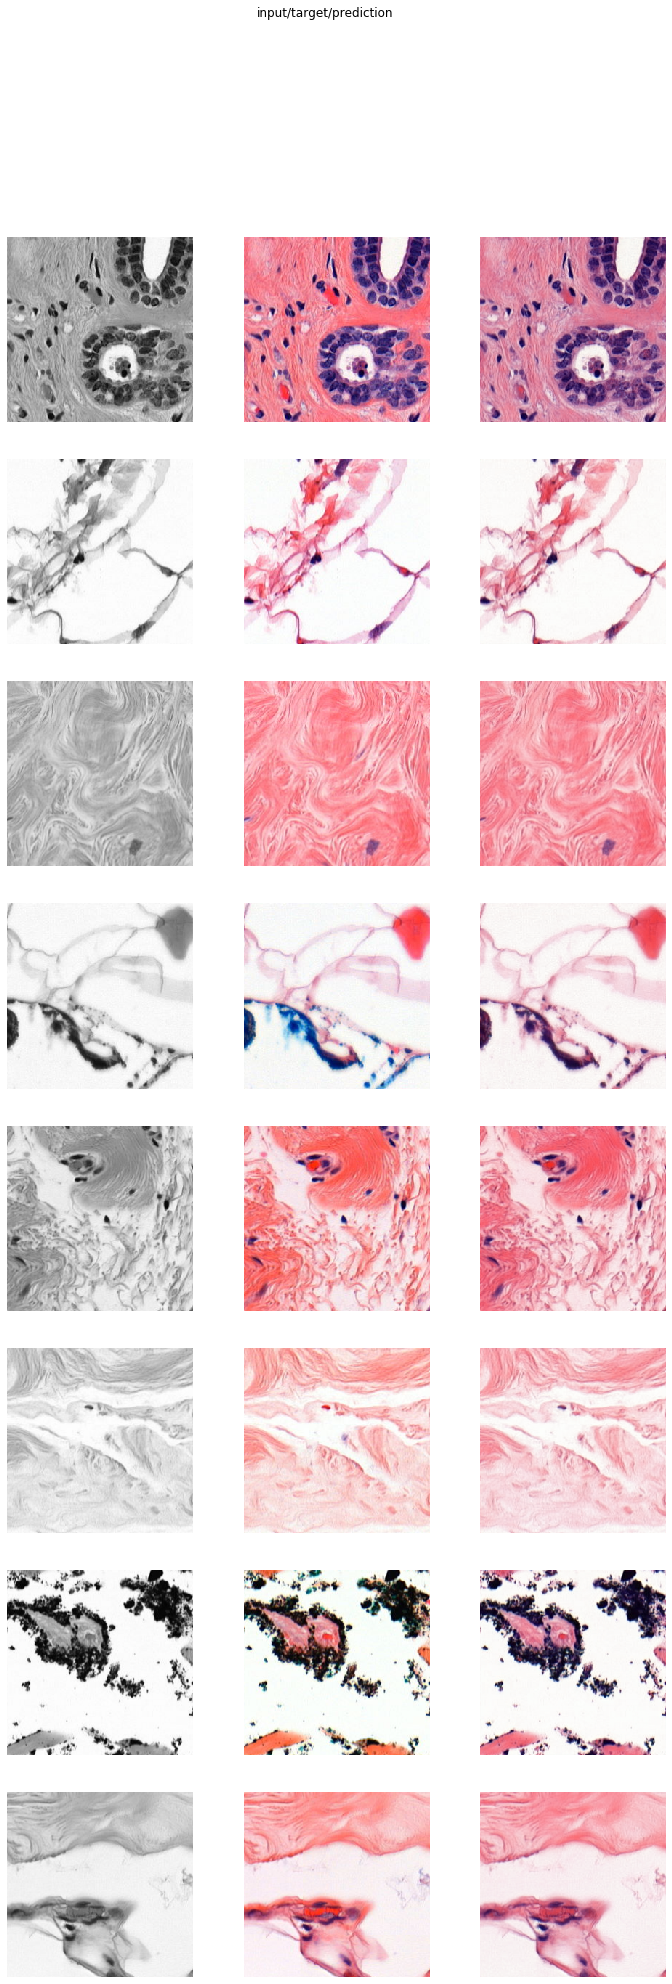

In [ ]:
norm.show_results()

In [ ]:
# export
class GradesClassifModel(BaseModule):
    def __init__(self, hparams, **kwargs):
        super().__init__(hparams, **kwargs)
        tfms = get_transforms(hparams.size)
        if hparams.concepts is not None and hparams.concept_classes is not None:
            conc_classes_df = pd.read_csv(hparams.concept_classes, index_col=0)
            if hparams.filt != 'all':
                ok = conc_classes_df.loc[conc_classes_df['type'] == hparams.filt].index.values
            else:
                ok = conc_classes_df.loc[conc_classes_df['type'] != 'garb'].index.values
            conc_df = pd.read_csv(hparams.concepts, index_col='patchId')
            def filt(x):
                return conc_df.loc[x.stem, 'concept'] in ok
        else:
            filt = None
        self.data = (ImageClassifDataset.
                     from_folder(Path(hparams.data), lambda x: x.parts[-3], classes=['1', '3'], extensions=['.png'], include=['1', '3'], open_mode=hparams.open_mode, filterfunc=filt).
                     split_by_csv(hparams.data_csv).
                     to_tensor(tfms=tfms, tfm_y=False))
        weight = np.float32((self.data.train.labels == '3').sum()/(self.data.train.labels == '1').sum())
        self.hparams.weight = weight
        self.loss = _get_loss(hparams.loss, weight if hparams.sample_mode == 0 else 1., hparams.reduction, device=self.main_device)
        if 'cbr' in hparams.model:
            args = map(int, hparams.model.split('_')[1:])
            base_model = CBR(*args)
            cut = -3
        else:
            base_model = timm.create_model(hparams.model, pretrained=not hparams.rand_weights)
            cut = -2
        self.base_model = nn.Sequential(*list(base_model.children())[:cut])
        head = [nn.AdaptiveAvgPool2d(1), nn.Flatten()]
        nf = get_num_features(self.base_model)
        p = hparams.dropout
        nc = 2 if hparams.loss == 'cross-entropy' else 1
        head += bn_drop_lin(nf, nf, p=p/2) + bn_drop_lin(nf, nc, p=p)
        self.head = nn.Sequential(*head)
        self.post_init()
        self.create_normalizer()
        
    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.eval()(x)
        loss = self.loss(y_hat, y)
        ret = {'val_loss': loss}
        n = y.shape[0]
        if self.hparams.loss == 'cross-entropy':
            y_hat = torch.softmax(y_hat, dim=1)
            y_hat = y_hat.argmax(dim=-1).view(n,-1)
        else:
            y_hat = torch.sigmoid(y_hat)
            y_hat = (y_hat > 0.5).view(n, -1)
        y = y.view(n,-1)
        ret['tp'] = ((y_hat)&(y==1)).float().sum()
        ret['tn'] = ((~y_hat)&(y==0)).float().sum()
        ret['fp'] = ((y_hat)&(y==0)).float().sum()
        ret['fn'] = ((~y_hat)&(y==1)).float().sum()
        return ret
        
    def validation_end(self, outputs):
        # OPTIONAL
        loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        log = {'val_loss': loss}
        tp = torch.stack([x['tp'] for x in outputs]).sum()
        fp = torch.stack([x['fp'] for x in outputs]).sum()
        tn = torch.stack([x['tn'] for x in outputs]).sum()
        fn = torch.stack([x['fn'] for x in outputs]).sum()
        for metric in self.metrics:
            try:
                name = metric.__name__
            except AttributeError:
                name = metric.func.__name__
                kws = metric.keywords
                for k in kws:
                    name += f'_{k}_{kws[k]}'
            log[name] = metric(tp, fp, tn, fn)
        return {'val_loss': loss, 'log': log}
        
    def create_normalizer(self):
        hparams = self.hparams
        if hparams.normalizer is not None:
            norm = DynamicUnet(hparams.normalizer, n_classes=3, input_shape=(3, hparams.size, hparams.size), pretrained=True)
            if hparams.norm_version is not None:
                save_dir = self.save_path.parents[1]/'normalizer'/f'{hparams.normalizer}/lightning_logs/version_{hparams.norm_version}/checkpoints'
                path = next(save_dir.iterdir())
                checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
                state_dict = {}
                for k in checkpoint['state_dict']:
                    state_dict[k.replace('unet.', '')] = checkpoint['state_dict'][k]
                norm.load_state_dict(state_dict)
                for p in norm.parameters():
                    p.requires_grad = False
            norm = norm.to(self.main_device)
            self.norm = norm.__call__        
        
    def forward(self, x):
        if hasattr(self, 'norm'):
            x = self.norm(x)
        x = self.base_model(x)
        x = self.head(x)
        return x
    
    def predict(self, x):
        pred = super().predict(x)
        if self.hparams.loss == 'cross-entropy':
            pred = torch.softmax(pred, dim=1)
        else:
            pred = torch.sigmoid(pred)
        return pred

In [ ]:
# export
class RNNAttention(BaseModule):
    def __init__(self, hparams, **kwargs):
        super().__init__(hparams, **kwargs)
        tfms = get_transforms(hparams.size)
        if hparams.concepts is not None and hparams.concept_classes is not None:
            conc_classes_df = pd.read_csv(hparams.concept_classes, index_col=0)
            if hparams.filt != 'all':
                ok = conc_classes_df.loc[conc_classes_df['type'] == hparams.filt].index.values
            else:
                ok = conc_classes_df.loc[conc_classes_df['type'] != 'garb'].index.values
            conc_df = pd.read_csv(hparams.concepts, index_col='patchId')
            def filt(x):
                return conc_df.loc[x.stem, 'concept'] in ok
        else:
            filt = None
        self.data = (ImageClassifDataset.
                     from_folder(Path(hparams.data), lambda x: x.parts[-3], classes=['1', '3'], extensions=['.png'], include=['1', '3'], open_mode=hparams.open_mode, filterfunc=filt).
                     split_by_csv(hparams.data_csv).
                     to_tensor(tfms=tfms, tfm_y=False))
        
        
    def forward(self, X, l):     
        Ai = gaussian_mask(*l[:3], self.hparams.glimpse_size, self.hparams.size)
        Aj = gaussian_mask(*l[3:], self.hparams.glimpse_size, self.hparams.size)
        x = Ai[None] @ X @ Aj.T[None]
        if hasattr(self, 'norm'):
            x = self.norm(x) 
        fx = self.t_x(x)
        y = self.fc(x)
        l = self.t_l(l)
        l = y * l
        l = self.t_a(l)
        return fx, y, l
    
    def training_step(self, batch, batch_nb):
        # REQUIRED
        X, Y = batch
        l0 = 'TODO: l0'
        loss = 0
        loss_prev = 0
        preds = []
        for t in range(self.hparams.n_glimpses):            
            fx, y_hat, l = self(X, l0)
            fts.append(fx)
            loss += self.loss(y_hat, Y)
            loss_a = ((torch.sigmoid(y_hat) - 0.5)**2).sum()
            if t > 0:
                loss -= loss_a + loss_prev / t
            loss_prev += loss_a
            loss += self.hparams.gamma * torch.exp(-torch.abs(l-l0))
            l0 = l
        # n_glimpses x bs x C x H x W
        fts = torch.cat(fts)
        fts = fts.view(fts.shape[1], -1)
        Y_hat = self.final_head(fts)
        loss += self.loss(Y_hat, Y)
        lr = self.sched.optimizer.param_groups[-1]['lr']
        log = {'train_loss': loss, 'learning_rate': lr}
        return {'loss': loss, 'log': log} 

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_train.ipynb.
Converted 02_predict.ipynb.
Converted 10_data.read.ipynb.
Converted 11_data.loaders.ipynb.
Converted 12_data.dataset.ipynb.
Converted 13_data.utils.ipynb.
Converted 14_data.transforms.ipynb.
Converted 20_models.plmodules.ipynb.
Converted 21_models.modules.ipynb.
Converted 22_models.utils.ipynb.
Converted 23_models.hooks.ipynb.
Converted 24_models.metrics.ipynb.
Converted 25_models.losses.ipynb.
Converted 80_params.defaults.ipynb.
Converted 81_params.parser.ipynb.
Converted 99_index.ipynb.
